In [1]:
# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define dataset path
dataset_path = "/content/drive/My Drive/Brain-Tumor-Classification-DataSet-master"
train_path = os.path.join(dataset_path, "Training")
test_path = os.path.join(dataset_path, "Testing")

In [4]:
test_path

'/content/drive/My Drive/Brain-Tumor-Classification-DataSet-master/Testing'

In [5]:
# Define image size
IMG_SIZE = 128  # Resize images to 128x128

In [6]:
# Function to load images from all subfolders
def load_data(directory):
    X = []
    y = []
    class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']  # Define expected subfolders

    # Ensure we are accessing correct subfolders
    for category in class_labels:
        class_path = os.path.join(directory, category)

        if not os.path.exists(class_path):  # Check if path exists
            print(f"Warning: Subfolder '{category}' not found in {directory}")
            continue

        print(f"Loading category: {category}")  # Debugging

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            # Ensure only image files are processed
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                print(f"Skipping non-image file: {img_path}")
                continue

            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
                if img is None:
                    print(f"Unreadable image: {img_path}")
                    continue

                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize
                X.append(img)
                y.append(category)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    if len(X) == 0:
        print(f"Error: No images loaded from {directory}")  # Debugging

    X = np.array(X) / 255.0  # Normalize pixel values
    X = X.reshape(len(X), -1)  # Flatten images
    return X, y

# Load Training and Testing Data
train_path = "/content/drive/My Drive/Brain-Tumor-Classification-DataSet-master/Training"
test_path = "/content/drive/My Drive/Brain-Tumor-Classification-DataSet-master/Testing"

X_train, y_train = load_data(train_path)
X_test, y_test = load_data(test_path)

# Debugging Output: Check the number of images loaded
print(f"Total training samples: {len(X_train)}")
print(f"Total testing samples: {len(X_test)}")

Loading category: glioma_tumor
Loading category: meningioma_tumor
Loading category: no_tumor
Loading category: pituitary_tumor
Loading category: glioma_tumor
Loading category: meningioma_tumor
Loading category: no_tumor
Loading category: pituitary_tumor
Total training samples: 2940
Total testing samples: 394


In [7]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [8]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Train SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train_scaled, y_train_encoded)

SVC(kernel='linear', random_state=42)

In [10]:
# Predict on test data
y_pred = svm_model.predict(X_test_scaled)

In [11]:
# Evaluate model
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.7538


In [12]:
# Classification report
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))


Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       1.00      0.25      0.40       100
meningioma_tumor       0.74      0.97      0.84       115
        no_tumor       0.68      1.00      0.81       105
 pituitary_tumor       0.87      0.74      0.80        74

        accuracy                           0.75       394
       macro avg       0.82      0.74      0.71       394
    weighted avg       0.81      0.75      0.71       394



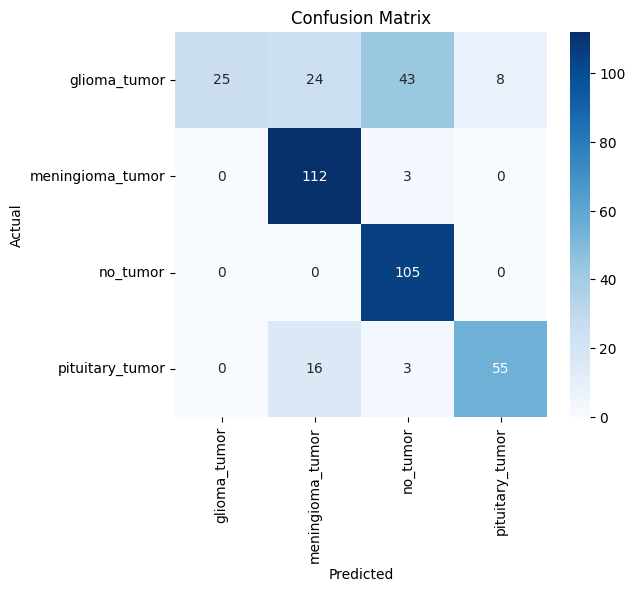

In [13]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
# Define the parameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

In [15]:
# Initialize the SVM model
svm = SVC()

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Use fewer parameter combinations to speed up tuning
param_grid = {
    'C': [0.1, 1, 10],  # Smaller range for faster search
    'kernel': ['linear', 'rbf'],  # Drop 'poly' to save time
}

# Initialize SVM model
svm = SVC()

# Faster GridSearchCV (cv=2 instead of 5)
grid_search = GridSearchCV(svm, param_grid, cv=2, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit model
grid_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train SVM with best parameters
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

# Predict on test set
y_pred = best_svm.predict(X_test)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best Hyperparameters: {'C': 10, 'kernel': 'rbf'}

Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.91      0.20      0.33       100
meningioma_tumor       0.69      0.98      0.81       115
        no_tumor       0.69      1.00      0.81       105
 pituitary_tumor       0.86      0.65      0.74        74

        accuracy                           0.73       394
       macro avg       0.79      0.71      0.67       394
    weighted avg       0.78      0.73      0.68       394


Confusion Matrix:
 [[ 20  33  39   8]
 [  0 113   2   0]
 [  0   0 105   0]
 [  2  17   7  48]]
